In [111]:
from astropy.io import fits
from astropy.cosmology import Planck18
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [112]:
clust_number = 9
snap_number = 104

In [113]:
r500 = fits.getheader(f'/home2/ferragamo/NIKA2_300_TS/Raphael_maps/Xray_theoretical_maps_CL{clust_number:04d}_snap_{snap_number:03d}_proj_0.fits', ext=1)['R500']
r200 = fits.getheader(f'/home2/ferragamo/NIKA2_300_TS/Raphael_maps/Xray_theoretical_maps_CL{clust_number:04d}_snap_{snap_number:03d}_proj_0.fits', ext=1)['R200']
z = fits.getheader(f'/home2/ferragamo/NIKA2_300_TS/Raphael_maps/Xray_theoretical_maps_CL{clust_number:04d}_snap_{snap_number:03d}_proj_0.fits', ext=1)['REDSHIFT']
r500, r200, z

r200_frac = 2

In [114]:
true_leff = np.load(f'/data7/NIKA2-300th/rwicker/Weiguang_sph_tests/true_leff_map_CL{clust_number:04d}_snap{snap_number:03d}.npy')
high_pass_synth_leff = np.load(f'/data7/NIKA2-300th/rwicker/synthetic_leff_maps/synthetic_leff_map_CL{clust_number:04d}_snap{snap_number:03d}.npy')
splash_density = np.load(f'/data7/NIKA2-300th/rwicker/splash_density_maps/ne_map_CL{clust_number:04d}_snap{snap_number:03d}.npy')

In [115]:
npix = len(splash_density)
bin_size = 2*r200_frac*r200 / npix
print(npix, bin_size)

860 10.00739534883721


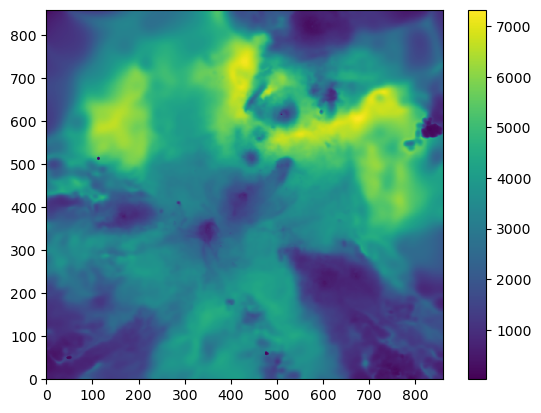

In [116]:
true_leff_map = plt.pcolormesh(true_leff)
plt.colorbar(true_leff_map)

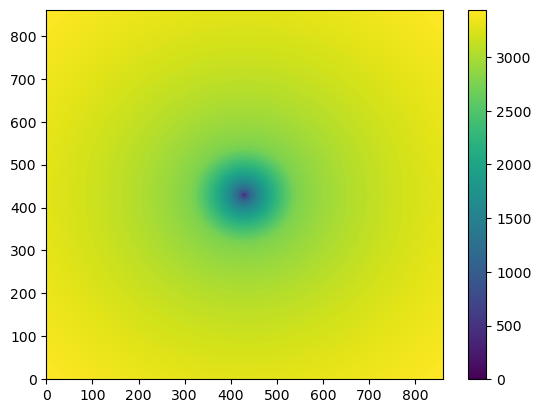

In [117]:
synth_leff_map = plt.pcolormesh(high_pass_synth_leff)
plt.colorbar(synth_leff_map)

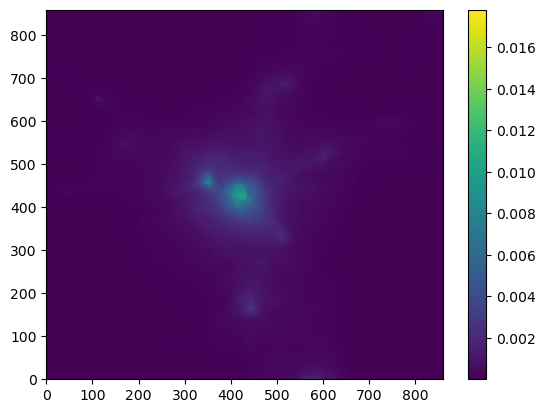

In [118]:
ne_map = plt.pcolormesh(splash_density)
plt.colorbar(ne_map)

In [119]:
nbin = 300
rbins_p = np.logspace(np.log10(0.005*r200), np.log10(r200_frac*r200), num=nbin+1)

xx, yy = np.meshgrid(np.linspace(-len(splash_density)//2*bin_size, len(splash_density)//2*bin_size, len(splash_density)),
                     np.linspace(-len(splash_density)//2*bin_size, len(splash_density)//2*bin_size, len(splash_density)))

dist = np.sqrt(xx**2 + yy**2)

/tmp/ipykernel_955643/1793012181.py:4: RuntimeWarning: Mean of empty slice
  ne_prof = np.append(ne_prof, np.nanmean(splash_density[(dist>rr0) & (dist<=rr1)]))


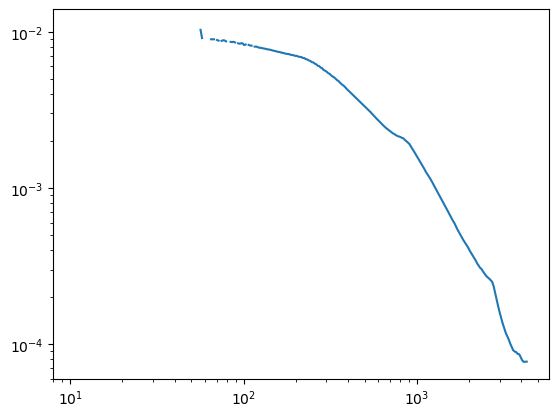

In [120]:
ne_prof = []
ne_prof.append(np.nanmean(splash_density[(dist<=rbins_p[0])]))
for i, (rr0, rr1) in enumerate(zip(rbins_p[:-1], rbins_p[1:])):
    ne_prof = np.append(ne_prof, np.nanmean(splash_density[(dist>rr0) & (dist<=rr1)]))

plt.loglog(rbins_p, ne_prof)

In [121]:
def beta_profile(r, n0, rc, b):
    return (n0**2)/(1+(r/rc)**2)**(3*b)

In [122]:
not_nan = np.where(~np.isnan(ne_prof))[0][1:]

In [123]:
popt, pcov = curve_fit(beta_profile, rbins_p[not_nan], ne_prof[not_nan])
popt

/tmp/ipykernel_955643/2052421356.py:2: RuntimeWarning: divide by zero encountered in divide
  return (n0**2)/(1+(r/rc)**2)**(3*b)
/tmp/ipykernel_955643/2052421356.py:2: RuntimeWarning: overflow encountered in divide
  return (n0**2)/(1+(r/rc)**2)**(3*b)


array([9.68665762e-02, 2.80759562e+02, 2.39046990e-01])

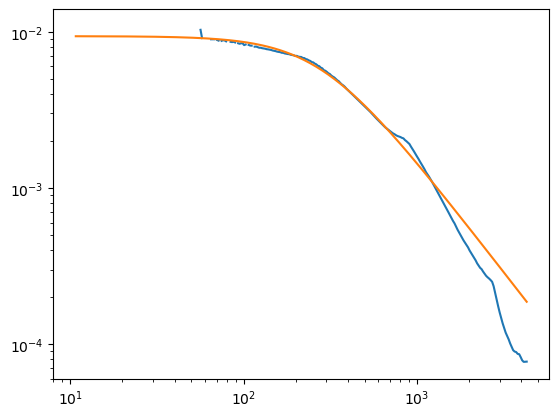

In [124]:
plt.loglog(rbins_p, ne_prof)
plt.loglog(rbins_p, beta_profile(rbins_p, *popt))

In [125]:
def centered_distance_cube(n):
    x,y,z = np.meshgrid(np.linspace(-2*r200, 2*r200, n), 
                        np.linspace(-2*r200, 2*r200, n),
                        np.linspace(-2*r200, 2*r200, n))
    return np.sqrt(x**2 + y**2 + z**2)

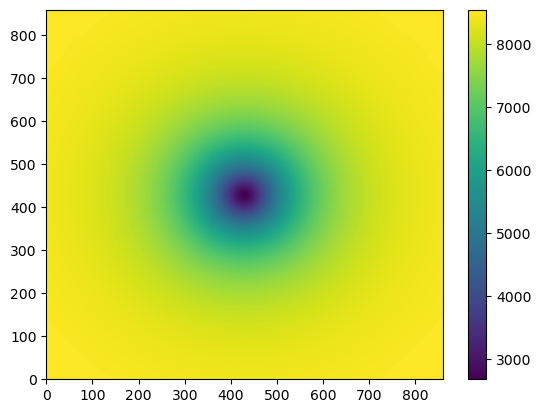

In [126]:
synthetic_beta_ne = beta_profile(centered_distance_cube(npix), *popt)

synthetic_beta_leff = (np.sum(synthetic_beta_ne, axis=2)*bin_size)**2 / (np.sum(synthetic_beta_ne**2, axis=2)*bin_size)
synthetic_beta_leff_map = plt.pcolormesh(synthetic_beta_leff)
plt.colorbar(synthetic_beta_leff_map)

In [127]:
print(synthetic_beta_leff.shape)
np.save(f'/data7/NIKA2-300th/rwicker/synthetic_leff_maps/beta_ne_synth_leff_CL{clust_number:04d}_snap_{snap_number:03d}.npy', synthetic_beta_leff)

(860, 860)
